In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import matplotlib.image as iplt
import cv2
import random
import tensorflow as tf
import sklearn.metrics as sm

from imgaug import augmenters as ai
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D,Flatten,Dense,MaxPooling2D,Dropout
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
#Iniciar dados
path = 'C:/Users/jose-/Desktop/Unifor/IA'
Name = ['Centro','Esquerda','Direita','Angulo','Aceleracao','Freios','Velocidade']
data = pd.read_csv(os.path.join(path,'driving_log.csv'),names = Name)
print(len(data))

53164


In [3]:
def VisualizeData():#visualizar os angulos dos dados
    nBins = 31
    hist,bins = np.histogram(data['Angulo'],nBins)
    centro = (bins[:-1]+bins[1:])*.5
    plt.bar(centro,hist,width=0.06)
    plt.xlim((-1,1))
    Valor_limite = 1000
    plt.plot((-1,1),(Valor_limite,Valor_limite))
    plt.show()

In [4]:
def RemoveRedundancia():#remover as redudâncias de zeros
    nBins = 31
    hist,bins = np.histogram(data['Angulo'],nBins)
    centro = (bins[:-1]+bins[1:])*.5
    valor_limite = 1000
    listaRemover = []
    for i in range(len(data['Angulo'])):
        if data['Angulo'][i]>=bins[15] and data['Angulo'][i]<=bins[15+1]:
            listaRemover.append(i)

    listaRemover = shuffle(listaRemover)
    listaRemover = listaRemover[valor_limite:]
    data.drop(data.index[listaRemover],inplace=True)
    hist,bins = np.histogram(data['Angulo'],nBins)

In [5]:
def buildDataSet():#pega o angulo e o caminho das imagens de centro
  imagesPath = []
  angulo = []

  for i in range(len(data)):
    indexData = data.iloc[i]
    imagesPath.append(indexData['Centro'])
    angulo.append(indexData['Angulo'])
  imagesPath = np.asarray(imagesPath)
  angulo = np.asarray(angulo)

  return imagesPath,angulo


In [6]:
def augmentedImage(path,angulo):#data augmentation
  img = iplt.imread(path)
  if np.random.rand()>0.5:
    transladar = ai.Affine(translate_percent={'x':(-.1,.1),'y':(-.1,.1)})
    img = transladar.augment_image(img)

  if np.random.rand()>0.5:
    zoom = ai.Affine(scale=(1,1.2))
    img = zoom.augment_image(img)

  if np.random.rand()>0.5:
    brilho = ai.Multiply((.5,1.2))
    img = brilho.augment_image(img)

  if np.random.rand()>0.5:
    img = cv2.flip(img,1)
    angulo = -angulo
    
  return img,angulo

In [7]:
def Preprocessing(img):#pre processamento
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255

  return img

In [8]:
def LoteGen(imgPath,anguloL,tamanho,treino):#função que gera a imagem
   while True:
     LotImg = []
     AnguloLot = []
     for i in range(tamanho):
      index = random.randint(0,len(imgPath)-1)
      if treino:
        img,angulo = augmentedImage(imgPath[index],anguloL[index])
      else:
        img = iplt.imread(imgPath[index])
        angulo = anguloL[index]
      img = Preprocessing(img)
      LotImg.append(img)
      AnguloLot.append(angulo)
      yield np.asarray(LotImg),np.asarray(AnguloLot)

In [9]:
def CreateModel():# cria o modelo cnn
  model = Sequential()
  model.add(Convolution2D(12,(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(MaxPooling2D((2,2),(1,3)))
  model.add(Convolution2D(36,(3,3),activation='elu'))
  model.add(MaxPooling2D((2,2),))
  model.add(Convolution2D(64,(5,5),activation='elu'))
  model.add(MaxPooling2D((2,2),))
  model.add(Convolution2D(128,(5,5),activation='elu'))
  model.add(MaxPooling2D((2,2),))
#redes totalmente conectadas
  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  model.add(Dense(50,activation='elu'))
  model.add(Dense(25,activation='elu'))
  model.add(Dense(1))
  model.compile(Adam(learning_rate=0.0001),loss='mse')

  model.summary()
  return model

In [10]:
imgsPathtot,angulotot = buildDataSet()
print(len(imgsPathtot))
imgsPath = imgsPathtot[24603:]
angulo = angulotot[24603:]
print(len(angulo))

53164
28561


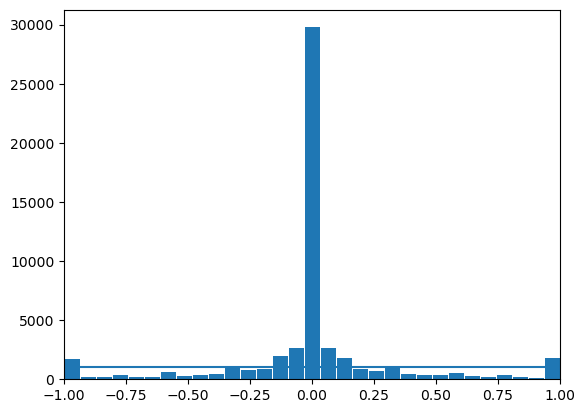

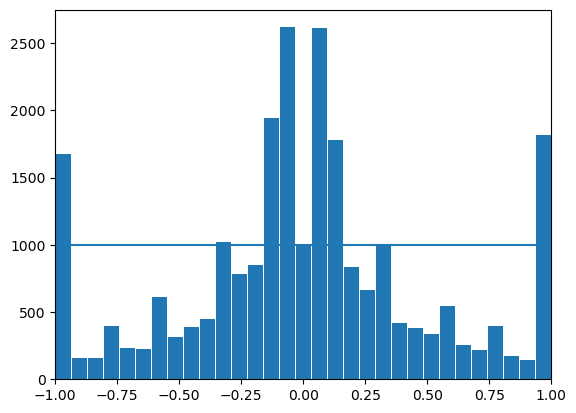

In [11]:

p = np.random.permutation(len(imgsPath))

VisualizeData()
RemoveRedundancia()
VisualizeData()

ImgsR = imgsPath[p]
AngulosR = angulo[p]

xTrain = ImgsR[0:int(len(ImgsR)*.8)]
yTrain = AngulosR[0:int(len(ImgsR)*.8)]

xVal = ImgsR[int(len(ImgsR)*.8):len(ImgsR)]
yVal = AngulosR[int(len(AngulosR)*.8):len(AngulosR)]

In [12]:
qtdTrain = 200
qtdValid = 200

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')]
callbacks.append(tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath='TheBest.h5', verbose=1, mode='min'))

In [13]:
model = CreateModel()


hist = model.fit(LoteGen(xTrain,yTrain,qtdTrain,True),steps_per_epoch=200,epochs=100,
                 validation_data=LoteGen(xVal,yVal,qtdValid,False),callbacks=callbacks,
                 validation_steps=200)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 199, 12)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 66, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 64, 36)        3924      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 32, 36)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 28, 64)        57664     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 14, 64)       0

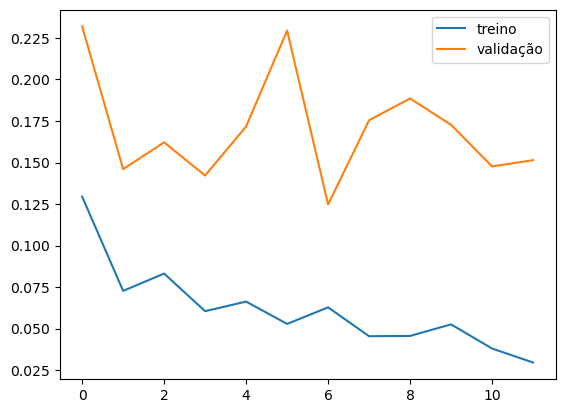

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['treino','validação'])
plt.show()

179/179 [==============================] - 5s 29ms/step


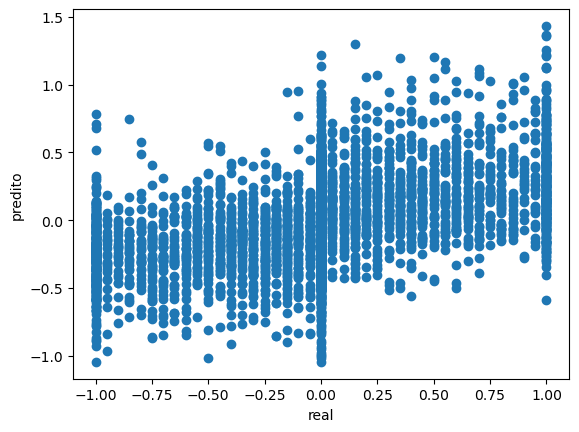

In [15]:
xVal1 = []
for i in range(len(xVal)):
    img1 = iplt.imread(xVal[i])
    img1 = Preprocessing(img1)
    xVal1.append(img1)
xVal1 = np.asarray(xVal1)
ypred = model.predict(xVal1)
plt.scatter(yVal,ypred)
plt.xlabel('real')
plt.ylabel('predito')

plt.show()

In [16]:
print("MAE (Mean absolute error) =", round(sm.mean_absolute_error(yVal, ypred), 2)) 
print("MSE (Mean squared error) =", round(sm.mean_squared_error(yVal, ypred), 2)) 
print("MDAE (Median absolute error) =", round(sm.median_absolute_error(yVal, ypred), 2)) 
print("EVS (Explain variance score) =", round(sm.explained_variance_score(yVal, ypred), 2)) 
print("R2 score =", round(sm.r2_score(yVal, ypred), 2))

MAE (Mean absolute error) = 0.3
MSE (Mean squared error) = 0.16
MDAE (Median absolute error) = 0.21
EVS (Explain variance score) = 0.19
R2 score = 0.19
